In [ ]:
!nvidia-smi

Tue Jun 15 16:49:42 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   64C    P8    11W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
!cp -r '/content/drive/My Drive/NihCAMProject/NIH small.zip' .

In [ ]:
!unzip 'NIH small.zip'

Streaming output truncated to the last 5000 lines.
  inflating: NIH small/00028897_014.png  
  inflating: NIH small/00028897_015.png  
  inflating: NIH small/00028897_016.png  
  inflating: NIH small/00028897_017.png  
  inflating: NIH small/00028897_018.png  
  inflating: NIH small/00028897_019.png  
  inflating: NIH small/00028897_020.png  
  inflating: NIH small/00028898_000.png  
  inflating: NIH small/00028899_000.png  
  inflating: NIH small/00028899_001.png  
  inflating: NIH small/00028899_002.png  
  inflating: NIH small/00028900_000.png  
  inflating: NIH small/00028901_000.png  
  inflating: NIH small/00028901_001.png  
  inflating: NIH small/00028902_000.png  
  inflating: NIH small/00028902_001.png  
  inflating: NIH small/00028902_002.png  
  inflating: NIH small/00028902_003.png  
  inflating: NIH small/00028902_004.png  
  inflating: NIH small/00028902_005.png  
  inflating: NIH small/00028902_006.png  
  inflating: NIH small/00028902_007.png  
  inflating: NIH small/00

In [ ]:
!mv 'NIH small' 'images'

In [ ]:
!mkdir data

In [ ]:
!mv 'images' 'data/'

In [ ]:
!cp -r '/content/drive/My Drive/NihCAMProject/data/labels' 'data/'

In [ ]:
%cd '/content/drive/My Drive/NihCAMProject/'

/content/drive/.shortcut-targets-by-id/1HkH6stga-Is10gJakvUONT2Cl34XUHce/NihCAMProject


In [ ]:
!pip3 install torchray
from torchray.attribution.grad_cam import grad_cam
from torchray.benchmark import plot_example

In [ ]:
from constructModel import load_model
from dataloaders import construct_dataloaders
import numpy as np
import pandas as pd
import os

In [ ]:
dataloaders = construct_dataloaders('nih', 1, 3, output_filenames=True)

In [ ]:
method = 'ce_short'
model_path = os.path.join('results', method, 'best_checkpoint')
model, _, _, _ = load_model(model_path)

Existing model was trained using ce


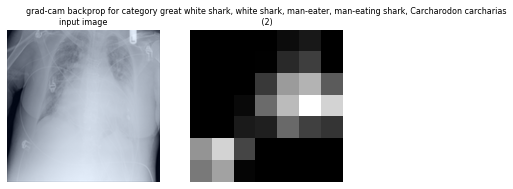

In [ ]:
class_num = 2
saliency_layer = 'features.denseblock4.denselayer16.conv2'
raw_cam = grad_cam(model, image, class_num, saliency_layer=saliency_layer)
plot_example(image, raw_cam*1000, 'grad-cam backprop', class_num)

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self, base_model):
      super(Net, self).__init__()
      self.base_model = base_model

    def forward(self, x):
      x = self.base_model(x)
      x = x.view(x.shape[0], 2, -1)
      x = F.softmax(x, dim=1)[:, 0, :]
      return x

In [ ]:
class_num = 3
map_thresholds = np.arange(0.1, 1, 0.1)
io_thresholds = np.arange(0.1, 1, 0.1)

results = eval_localization(dataloaders['bbox'], model, class_num, map_thresholds, io_thresholds, method='ce', eval_method='iou')

In [ ]:
model.base_model.features.denseblock2

_DenseBlock(
  (denselayer1): _DenseLayer(
    (norm1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu1): ReLU(inplace=True)
    (conv1): Conv2d(128, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu2): ReLU(inplace=True)
    (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  )
  (denselayer2): _DenseLayer(
    (norm1): BatchNorm2d(160, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu1): ReLU(inplace=True)
    (conv1): Conv2d(160, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu2): ReLU(inplace=True)
    (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  )
  (denselayer3): _DenseLayer(
    (norm1): BatchNorm2d(192, eps=1e-05, moment

In [ ]:
map_thresholds = np.arange(0.1, 1, 0.1)
io_thresholds = np.arange(0.1, 1, 0.1)

#for method in ['ce', 'ldam', 'effective_a_0.9999']:
for method in ['ce_short']:
  print(method)
  model_path = os.path.join('results', method, 'best_checkpoint')
  model, _, _, _ = load_model(model_path)

  for class_num in [0, 2, 3, 5]:
    print(class_num)
    results = eval_localization(dataloaders['bbox'], model, class_num, map_thresholds, io_thresholds, method='ce', eval_method='iou')
    df = pd.DataFrame(results)
    path = os.path.join("results", method, f"iou_{class_num}.csv")
    df.to_csv(path, index=False)

ce_short
Existing model was trained using ce
0
2
3
5


In [ ]:
from REGISTRY import double_class_methods
import numpy as np
from PIL import Image
import torch

def eval_localization(dataloader, model, class_num, map_thresholds, io_thresholds=[0.1], method='ce', eval_method='iou'):

    if method in double_class_methods:
      model = Net(model)
      saliency_layer = 'base_model.base_model.features.denseblock4.denselayer12.conv2'
    else:
      saliency_layer = 'base_model.features.denseblock2.denselayer12.conv2'

    num_correct_pred = 0
    num_images_examined = 0

    def compute_ior(activated_masks, gt_mask):
        intersection_masks = np.logical_and(activated_masks, gt_mask)

        detected_region_areas = np.sum(activated_masks, axis=(1, 2))
        intersection_areas = np.sum(intersection_masks, axis=(1, 2))

        ior = np.divide(intersection_areas, detected_region_areas)

        return ior

    def compute_iou(activated_masks, gt_mask):
        intersection_masks = np.logical_and(activated_masks, gt_mask)
        union_masks = np.logical_or(activated_masks, gt_mask)

        intersection_areas = np.sum(intersection_masks, axis=(1, 2))
        union_areas = np.sum(union_masks, axis=(1, 2))

        iou = np.divide(intersection_areas, union_areas)

        return iou

    map_thresholds = np.array(map_thresholds)
    map_thresholds = map_thresholds[:, np.newaxis, np.newaxis]

    for data in dataloader:

        input, label, filename, bbox, bbox_label = data

        if bbox_label[0] != dataloader.Dataset.PRED_LABEL[class_num]:
          continue

        num_images_examined += 1

        #label_index = next((x for x in range(len(FINDINGS)) if FINDINGS[x] == label))


        # get cam map
        raw_cam = grad_cam(model, input, class_num, saliency_layer=saliency_layer)
        raw_cam = np.array(Image.fromarray(raw_cam.squeeze(0).squeeze(0).detach().numpy()).resize((224,224)))
        raw_cam = (raw_cam - raw_cam.min()) / (raw_cam.max() - raw_cam.min() + 1e-12)

        raw_cams = np.broadcast_to(raw_cam, shape=(len(map_thresholds), raw_cam.shape[0], raw_cam.shape[1]))
        activation_masks = np.greater_equal(raw_cams, map_thresholds)
        #print(np.sum(activation_masks))

        # bounding box as a mask
        bbox = bbox.type(torch.cuda.IntTensor)
        bbox_mask = np.zeros(raw_cam.shape, dtype=bool)
        bbox_mask[bbox[0, 1]: bbox[0, 1] + bbox[0, 3], bbox[0, 0]: bbox[0, 0] + bbox[0, 2]] = True

        if eval_method == 'ior':
            ior = compute_ior(activation_masks, bbox_mask)
            ior = np.broadcast_to(ior, (len(io_thresholds), len(map_thresholds)))
            num_correct_pred += np.greater_equal(ior, io_thresholds.reshape(-1,1))

        if eval_method == 'iou':
            iou = compute_iou(activation_masks, bbox_mask)
            iou = np.broadcast_to(iou, (len(io_thresholds), len(map_thresholds)))
            num_correct_pred += np.greater_equal(iou, io_thresholds.reshape(-1,1))

    accuracy = num_correct_pred / num_images_examined
    return accuracy


In [ ]:
!python3 main.py --alias 'ce_short' --method 'ce' --arch 'shortdensenet121' --dataset 'nih' --lr 0.01 --alpha 0.9999 --lamda 0.05 --imp 3 --weight-decay 1e-3 --optimizer 1 --scheduler 1 --num-epochs 30 #--find-new-best 0 --use-model 'best'

In [ ]:
!python3 evalScript.py --alias 'ce_short' --method 'ce' --checkpoint 'best_checkpoint'

Existing model was trained using ce


In [ ]:
!python3 main.py --alias 'anchor_a_0.5_l_0.05' --method 'anchor' --arch 'densenet121' --dataset 'nih' --lr 0.001 --alpha 0.5 --lamda 0.05 --imp 3 --weight-decay 1e-3 --optimizer 1 --scheduler 1 --num-epochs 10 --find-new-best 0 --use-model 'checkpoint_3'